# VRNN SINUS

In [1]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 1210 (delta 62), reused 28 (delta 13), pack-reused 1087
Receiving objects: 100% (1210/1210), 49.98 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (731/731), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=21067 sha256=1885e56702a4df99ae7a88df7599f8e29fb414fe9b5184836674cea21fe93e73
  Stored in directory: /tmp/pip-ephem-wheel-cache-xirc1t48/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [2]:
!pip install parse

  Created wheel for parse: filename=parse-1.19.0-cp36-none-any.whl size=24582 sha256=ae4bccfb815a948bc41b83addf0bfcc74b7e953ac0918992b9fbbc1bd1a0633e
  Stored in directory: /root/.cache/pip/wheels/c0/39/ea/e2fd678bd130953f5438470b8dfa529f00787e9b8b92b27467
Successfully built parse


In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket
import numpy as np
from torchvision import datasets, transforms
import torch.distributions as td
from deepflows import Utils as utils
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
from math import log, pi, exp
from deepflows.data_generators import stochasticMovingMnist
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.nn.utils import weight_norm
from scipy.signal import savgol_filter

In [4]:
device = utils.set_gpu(True)

# Load data 

In [5]:
class SinusWithNoise(object):
    """Data Handler that creates Bouncing MNIST dataset on the fly."""
    def __init__(self, epoch_length=1000, seq_len=20, deterministic=True, step_length=0.1, timeblocks=2, noise_variance=0.1,amplitude_noise = 0.1, doublemodulation=False):
        self.seq_len = seq_len
        self.step_length = step_length
        self.deterministic = deterministic
        self.timeblocks = timeblocks
        self.std = noise_variance
        self.N = epoch_length
        self.A_e = amplitude_noise
        self.DM = doublemodulation
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        length=self.timeblocks*self.seq_len
        x = np.arange(0,length)*self.step_length
        y_offset = np.random.rand(1)*3
        if self.deterministic==False:
          x= x + np.random.rand(1)*pi*2
        y = np.sin(x)+y_offset
        if self.deterministic==False:
          y=y+np.random.normal(self.A_e*np.sin(3*np.random.rand(1)*x + np.random.rand(1)*pi*2), self.A_e+0.001+self.A_e*np.sin(3*np.random.rand(1)*x + np.random.rand(1)*pi*2)*self.std, length)
        

        return np.reshape(y, [self.timeblocks, self.seq_len])

Extracting Mnist/MNIST/raw/train-images-idx3-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Mnist/MNIST/raw



Extracting Mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Mnist/MNIST/raw


Extracting Mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


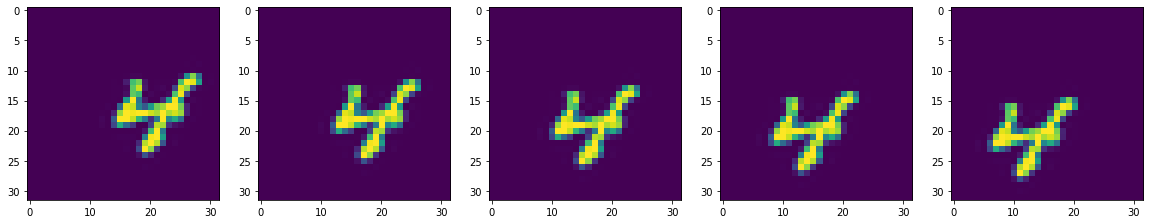

In [6]:
batch_size = 128
data_set_type = "mnist"

n_frames = 10
three_channels = False
testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                            deterministic=False, three_channels=three_channels, step_length=2, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=20, num_digits=1, 
                                              deterministic=False, three_channels=three_channels, step_length=2, normalize=False)
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)
x_plot = next(iter(train_loader))[0]


fig, ax = plt.subplots(1, 5, figsize = (20,5))
ax[0].imshow(x_plot[0].squeeze(0))
ax[1].imshow(x_plot[1].squeeze(0))
ax[2].imshow(x_plot[2].squeeze(0))
ax[3].imshow(x_plot[3].squeeze(0))
ax[4].imshow(x_plot[4].squeeze(0))
plt.show()

In [7]:
class LinearLayer(nn.Module):
  def __init__(self, input, output, types="None"):
    super(LinearLayer, self).__init__()
    
    if types == 'none':
      self.net=nn.Linear(input, output)
    
    if types == 'wn':
      self.net=weight_norm(nn.Linear(input, output))

    if types == 'bn':
      self.net=nn.Sequential(nn.Linear(input, output),
                             nn.BatchNorm1d(output),)

  def forward(self,x):
    return self.net(x)


class ActFun(nn.Module):
  def __init__(self, non_lin):
    super(ActFun, self).__init__()
    if non_lin=='relu':
      self.net=nn.ReLU()
    if non_lin=='leakyrelu':
      self.net=nn.LeakyReLU(negative_slope=0.20)

  def forward(self,x):
    return self.net(x)
class Softplus_pluseps(nn.Module):
  def __init__(self):
    super(Softplus_pluseps, self).__init__()
    self.net=nn.Softplus()

  def forward(self,x):
    return self.net(x) + 1e-6

In [9]:
class VRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128):
    super(VRNN, self).__init__()

    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "bn"
    hidden_neurons = 512
    hidden_neurons_x_t = 256
    hidden_neurons_z_t = 512

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"), #BN here
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    

    self.enc = nn.Sequential(        
        LinearLayer(hidden_neurons_x_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        Softplus_pluseps(),
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        # IF BERNOULLI LOSS
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_z_t + hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    self.reset_parameters()

  def forward(self, xt):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    kld_loss = 0
    nll_loss =0

    for t in range(xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])

      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      # Encoder
      enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
      enc_mean_t = self.enc_mean(enc_t)
      enc_std_t = self.enc_std(enc_t)

      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      # Decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      #px=td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) #maybe x_features here
      #px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none')
      #nll_loss += px.sum(1).mean()
      nll_loss += self._nll_bernoulli(dec_mean_t, xt[:, t, :]).mean()
      

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
    return kld_loss, nll_loss

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)
   
  def sample(self, seq_len):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

    sample = []
    for t in range(seq_len):

      ht = ht.view(-1, ht.shape[-1])
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      #sampling and reparameterization
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      #decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      phi_x_t = self.phi_x_t(dec_mean_t)

      #recurrence
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
      sample.append(dec_mean_t.data)
    return sample

  def prediction(self, xt, steps = 5):
    ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
		
    bx, x_dim = xt.shape
    preds = torch.zeros(steps, bx, x_dim)
    
    for i in range(0, steps):
      preds[i] = xt
      phi_x_t = self.phi_x_t(xt)
      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     

      #sampling and reparameterization
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()
      phi_z_t = self.phi_z(z_t)

      #decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)

      #recurrence
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      xt = dec_mean_t
    return preds

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

In [10]:
x=next(iter(train_loader)).float().to(device)
x=x.view(batch_size, n_frames, -1)

model = VRNN(x.shape[-1], x_batch=x.shape[0], h_dim = 512, z_dim = 256).to(device) #hdim 256

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print_every = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=250, factor = 0.5)
clip = 10
n_epochs = 10
counter = 0

for epoch in range(1, n_epochs + 1):
  print(optimizer.param_groups[0]['lr'])
  for batch_idx, data in enumerate(tqdm(train_loader, desc='Batch', leave=False)):

    data = data.to(device)
    data = (data - data.min()) / (data.max() - data.min())
    data=data.view(batch_size, n_frames, -1)
    
    #Warm up
    beta = min(1, 0.001 + (counter+1)/1500)
    counter += 1
    
    optimizer.zero_grad()
    kld_loss, nll_loss = model(data)
    loss = beta*kld_loss + nll_loss
    loss.backward()
    optimizer.step()

    nn.utils.clip_grad_norm_(model.parameters(), clip)
    scheduler.step(loss)

    #printing
    with torch.no_grad():
      model.eval()
      if batch_idx % print_every == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(epoch, batch_idx * len(data), 
                                                                                                len(train_loader.dataset),
                                                                                                100. * batch_idx / len(train_loader),
                                                                                                kld_loss / batch_size, 
                                                                                                nll_loss / batch_size))
        sample = model.sample(10)
        fig, ax = plt.subplots(2, 6, figsize = (20,5))
        ax[0,0].imshow(sample[0][0].view(32,32).detach().cpu().numpy())
        ax[0,1].imshow(sample[1][0].view(32,32).detach().cpu().numpy())
        ax[0,2].imshow(sample[2][0].view(32,32).detach().cpu().numpy())
        ax[0,3].imshow(sample[3][0].view(32,32).detach().cpu().numpy())
        ax[0,4].imshow(sample[4][0].view(32,32).detach().cpu().numpy())
        ax[0,5].imshow(sample[5][0].view(32,32).detach().cpu().numpy())

        preds = model.prediction(data[:, 0, :], steps=6)
        ax[1,0].imshow(preds[0][0].view(32,32).detach().cpu().numpy())
        ax[1,1].imshow(preds[1][0].view(32,32).detach().cpu().numpy())
        ax[1,2].imshow(preds[2][0].view(32,32).detach().cpu().numpy())
        ax[1,3].imshow(preds[3][0].view(32,32).detach().cpu().numpy())
        ax[1,4].imshow(preds[4][0].view(32,32).detach().cpu().numpy())
        ax[1,5].imshow(preds[5][0].view(32,32).detach().cpu().numpy())
        plt.pause(1e-6)
    model.train()

KeyboardInterrupt: ignored

In [28]:
class VRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128, res_q = False, learnableinit = False):
    super(VRNN, self).__init__()
    self.res_q = res_q
    self.learnableinit = learnableinit
    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "wn"
    hidden_neurons = 256
    hidden_neurons_x_t = 100
    hidden_neurons_z_t = 100

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus()
        )
    

    self.enc = nn.Sequential(        
        LinearLayer(hidden_neurons_x_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        nn.Softplus(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        nn.Softplus()
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        
        #nn.Tanh()
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_z_t + hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    self.reset_parameters()
    if self.learnableinit:
      self.ht = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.ct = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.z_mean = nn.Parameter(torch.zeros( self.x_batch, self.z_dim)).to(device)
      self.z_mean_enc = nn.Parameter(torch.zeros( self.x_batch, self.z_dim)).to(device)
  def forward(self, xt):
    ht, ct, lastprior_mean_t,lastenc_mean_t = self.get_init()
    kld_loss = 0
    nll_loss =0

    for t in range(xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])

      ht = ht.view(-1, ht.shape[-1])

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)
      if self.temporal_skip:
        prior_mean_t = lastprior_mean_t+prior_mean_t
        lastprior_mean_t = prior_mean_t

      # Encoder
      enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
      enc_mean_t = self.enc_mean(enc_t)
      enc_std_t = self.enc_std(enc_t)
      if self.res_q:
        enc_mean_t = prior_mean_t+enc_mean_t
      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
      phi_z_t = self.phi_z(z_t)

      # Decoder
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      # px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none') #USE SIGMOID IN DECODER MEAN OUTPUT
      # px = F.mse_loss(dec_mean_t, xt[:, t, :], reduction='none') #USE TANH IN DECODER MEAN OUTPUT
      
      nll_loss += px.sum(1).mean()
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(1), (ht, ct))
      
    return kld_loss, nll_loss

  def get_init(self):
    if self.learnableinit:
      ht = self.ht
      ct = self.ct
      z_mean = self.z_mean
      z_mean_enc = self.z_mean_enc
    else:
      ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      z_mean = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
      z_mean_enc = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
    return ht, ct, z_mean, z_mean_enc

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

  
  def OnestepPredict(self, xt):
    ht, ct, lastprior_mean_t,_ = self.get_init()
    data_list = []

    sample=[]
    for i in range(0, xt.shape[1]):
      xt_features = self.phi_x_t(xt[:, i, :])
      ht=ht.view(self.x_batch, -1)

      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      
      # dec_mean_t for other losses than normal dist
      sample.append(x_sample)
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) #LSTM
      
    return sample

  def PredictionAfterTsteps(self, xt, tsteps=6):

    if xt.shape[1] < tsteps:
      assert 'Predictions are dependent on x, so x must be larger than tsteps'
    ht, ct, lastprior_mean_t,_ = self.get_init()

    data_list = []
    predictions=[]
    
    for i in range(0, tsteps):

      xt_features = self.phi_x_t(xt[:, i, :])

      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)  
         

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) # LSTM
      
    
    
    for i in range(tsteps,xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht=ht.view(self.x_batch,-1)
      
      prior_t = self.prior(ht)
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)     
      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()

      predictions.append(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([xt_features, phi_z_t], 1).unsqueeze(1), (ht, ct)) 
    return predictions

In [12]:
class VRNN_V2(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128, res_q = False, learnableinit = False, smoothing_step = False):
    super(VRNN_V2, self).__init__()
    self.res_q = res_q
    self.learnableinit = learnableinit
    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    self.smoothing_step = smoothing_step 
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "wn"
    hidden_neurons = 256
    hidden_neurons_x_t = 100
    hidden_neurons_z_t = 100

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    
    if not self.smoothing_step:
      self.enc = nn.Sequential(        
          LinearLayer(hidden_neurons_x_t + n_layers*h_dim, hidden_neurons, norm_type),
          ActFun(non_lin),
          LinearLayer(hidden_neurons, hidden_neurons, norm_type),
          ActFun(non_lin),
          )
    else:
      # This is when calculating zt backwards
      self.enc = nn.Sequential(        
          LinearLayer(n_layers*h_dim, hidden_neurons, norm_type),
          ActFun(non_lin),
          LinearLayer(hidden_neurons, hidden_neurons, norm_type),
          ActFun(non_lin),
          )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        Softplus_pluseps(),
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        
        #nn.Tanh()
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    if self.smoothing_step:
      self.lstm_at = nn.LSTM(input_size = (n_layers*h_dim + hidden_neurons_x_t),
                          num_layers = n_layers,
                          batch_first = True,
                          hidden_size = h_dim).to(device)
    self.reset_parameters()
    if self.learnableinit:
      self.ht = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.ct = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.z_tp = nn.Parameter(torch.zeros(self.x_batch, self.z_dim)).to(device)
      self.z_t = nn.Parameter(torch.zeros( self.x_batch, self.z_dim)).to(device)
      self.a_t = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.a_ct = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

  def forward(self, xt):
    ht, ct, z_tp, z_t, a_t, a_ct = self.get_init()
    kld_loss = 0
    nll_loss = 0
    list_enc_mean = []
    list_enc_std = []
    list_prior_mean = []
    list_prior_std = []
    list_ht = []

    list_phi_x_t = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for t in range(1, xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_tp = td.Normal(prior_mean_t, prior_std_t).rsample()


      # Encoder
      if not self.smoothing_step:
        enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        list_enc_mean.append(enc_mean_t)
        list_enc_std.append(enc_std_t)

      
      # Get list ## This is not pretty but temp... maybe
      list_prior_mean.append(prior_mean_t)
      list_prior_std.append(prior_std_t)
      list_ht.append(ht)
      list_phi_x_t.append(phi_x_t)

      
      # Redefine
      phi_x_t_prev = phi_x_t
    ##Smoothing step
    if self.smoothing_step:
      list_at =[]
      # Calculate a_t
      for t in reversed(range(0,len(list_ht))):
        _, (a_t, a_ct) = self.lstm_at(torch.cat([list_ht[t], list_phi_x_t[t]], 1).unsqueeze(1), (a_t, a_ct))
        list_at.append(a_t.view(self.x_batch, -1))
      list_at.reverse()





    # Generative part and inference
    ## Decoder input list of ht, zt, at, and dist zt and dist zt_p
    for t in range(1,xt.shape[1]):
      if not self.smoothing_step:
        enc_mean_t = list_enc_mean[t-1]
        enc_std_t = list_enc_std[t-1]
      else:
        enc_t = self.enc(torch.cat([list_at[t-1]], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
      
        
        
      
      
      prior_mean_t = list_prior_mean[t-1]
      prior_std_t = list_prior_std[t-1]
      if self.res_q:
        enc_mean_t = prior_mean_t+enc_mean_t
      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
      ht = list_ht[t-1]
      
      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      # px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none') #USE SIGMOID IN DECODER MEAN OUTPUT
      # px = F.mse_loss(dec_mean_t, xt[:, t, :], reduction='none') #USE TANH IN DECODER MEAN OUTPUT
      
      nll_loss += px.sum(1).mean()
    return kld_loss, nll_loss

  def get_init(self):
    if self.learnableinit:
      ht = self.ht
      ct = self.ct
      z_tp = self.z_tp
      z_t = self.z_t
      a_t = self.a_t
      a_ct = self.a_ct
    else:
      ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      z_tp = Variable(torch.zeros(self.x_batch, self.z_dim)).to(device)
      z_t = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
      a_t = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      a_ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    return ht, ct, z_tp, z_t, a_t, a_ct
    

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

  
  def PredictionAfterTsteps_warmup(self,xt, tsteps = 6):
    ht, ct, z_tp, z_t, a_t, a_ct = self.get_init()
    kld_loss = 0
    nll_loss = 0
    list_enc_mean = []
    list_enc_std = []
    list_prior_mean = []
    list_prior_std = []
    list_ht = []
    predictions = []
    if not self.smoothing_step:
      list_zt = []
    list_phi_x_t = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for t in range(1, tsteps):
      phi_x_t = self.phi_x_t(xt[:, t, :])
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_tp = td.Normal(prior_mean_t, prior_std_t).rsample()


      # Encoder
      if not self.smoothing_step:
        enc_t = self.enc(torch.cat([phi_x_t, ht], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
        list_enc_mean.append(enc_mean_t)
        list_enc_std.append(enc_std_t)
        list_zt.append(z_t)
      
      # Get list ## This is not pretty but temp... maybe
      list_prior_mean.append(prior_mean_t)
      list_prior_std.append(prior_std_t)
      list_ht.append(ht)
      list_phi_x_t.append(phi_x_t)

      
      # Redefine
      phi_x_t_prev = phi_x_t
    ##Smoothing step
    if self.smoothing_step:
      list_at =[]
      # Calculate a_t
      for t in reversed(range(0,len(list_ht))):
        _, (a_t, a_ct) = self.lstm_at(torch.cat([list_ht[t], list_phi_x_t[t]], 1).unsqueeze(1), (a_t, a_ct))
        list_at.append(a_t.view(self.x_batch, -1))
      list_at.reverse()





    # Generative part and inference
    ## Decoder input list of ht, zt, at, and dist zt and dist zt_p
    recons = []
    for t in range(1, tsteps):
      if not self.smoothing_step:
        enc_mean_t = list_enc_mean[t-1]
        enc_std_t = list_enc_std[t-1]

      else:
        enc_t = self.enc(torch.cat([list_at[t-1]], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        
      
      
      prior_mean_t = list_prior_mean[t-1]
      prior_std_t = list_prior_std[t-1]
      if self.res_q:
        enc_mean_t = prior_mean_t+enc_mean_t
      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
      ht = list_ht[t-1]
      
      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      recons.append(x_sample)
    x_sample = xt[:, tsteps, :] ## Might aswell give the true value at first.
    Prediction_loss = 0
    z_t = z_tp
    for i in range(tsteps,xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht], dim=1))
      prior_mean_t = self.prior_mean(prior_t)

      
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      Prediction_loss += -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, i, :]) 
      predictions.append(x_sample)

      # Redefine
      phi_x_t_prev = xt_features
    return recons, predictions, Prediction_loss

  def PredictionAfterTsteps(self, xt, tsteps=6):

    if xt.shape[1] < tsteps:
      assert 'Predictions are dependent on x, so x must be larger than tsteps'
    ht, ct, z_t, _, _, _ = self.get_init()
    data_list = []
    predictions = []
    one_step = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for i in range(1, tsteps):

      xt_features = self.phi_x_t(xt[:, i, :])

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      
      one_step.append(x_sample)

      # Redefine
      phi_x_t_prev = xt_features
      

    x_sample = xt[:, tsteps, :] ## Might aswell give the true value at first.
    Prediction_loss = 0

    for i in range(tsteps, xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht], dim=1))
      prior_mean_t = self.prior_mean(prior_t)

      
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      Prediction_loss += -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, i, :]) 
      predictions.append(x_sample)

      

      # Redefine
      phi_x_t_prev = xt_features
    return one_step, predictions, Prediction_loss

In [47]:
class SRNN(nn.Module):
  def __init__(self, x_channels, x_batch, h_dim = 256, z_dim = 128, res_q = False, learnableinit = False, smoothing_step = False):
    super(SRNN, self).__init__()
    self.res_q = res_q
    self.learnableinit = learnableinit
    self.h_dim = h_dim
    self.z_dim = z_dim
    self.x_channels = x_channels
    self.x_batch = x_batch
    self.smoothing_step = smoothing_step 
    n_layers = 1
    
    self.n_layers = n_layers
    
    non_lin = "leakyrelu"
    norm_type = "wn"
    hidden_neurons = 256
    hidden_neurons_x_t = 100
    hidden_neurons_z_t = 100

    self.phi_x_t = nn.Sequential(
        LinearLayer(x_channels, hidden_neurons, "none"),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons_x_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.phi_z = nn.Sequential(
        LinearLayer(z_dim, hidden_neurons_z_t, "none"),
        ActFun(non_lin),
        )
    
    
    self.prior = nn.Sequential(
        LinearLayer(n_layers * h_dim + z_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.prior_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        )
    self.prior_std = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    
    if not self.smoothing_step:
      self.enc = nn.Sequential(        
          LinearLayer(hidden_neurons_x_t + n_layers*h_dim + z_dim, hidden_neurons, norm_type),
          ActFun(non_lin),
          LinearLayer(hidden_neurons, hidden_neurons, norm_type),
          ActFun(non_lin),
          )
    else:
      # This is when calculating zt backwards
      self.enc = nn.Sequential(        
          LinearLayer(n_layers*h_dim + z_dim, hidden_neurons, norm_type),
          ActFun(non_lin),
          LinearLayer(hidden_neurons, hidden_neurons, norm_type),
          ActFun(non_lin),
          )
    self.enc_mean = nn.Sequential(
        LinearLayer(hidden_neurons, z_dim, "none")
        )
    self.enc_std = nn.Sequential( 
        LinearLayer(hidden_neurons, z_dim, "none"),
        Softplus_pluseps(),
        )
    

    self.dec = nn.Sequential(
        LinearLayer(hidden_neurons_z_t + n_layers*h_dim, hidden_neurons, norm_type),
        ActFun(non_lin),
        LinearLayer(hidden_neurons, hidden_neurons, norm_type),
        ActFun(non_lin),
        )
    self.dec_std = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        Softplus_pluseps(),
        )
    self.dec_mean = nn.Sequential(
        LinearLayer(hidden_neurons, x_channels, "none"),
        
        #nn.Tanh()
        #nn.Sigmoid()
        )
    

    self.lstm = nn.LSTM(input_size = (hidden_neurons_x_t),
                        num_layers = n_layers,
                        batch_first = True,
                        hidden_size = h_dim).to(device)
    if self.smoothing_step:
      self.lstm_at = nn.LSTM(input_size = (n_layers*h_dim + hidden_neurons_x_t),
                          num_layers = n_layers,
                          batch_first = True,
                          hidden_size = h_dim).to(device)
    self.reset_parameters()
    if self.learnableinit:
      self.ht = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.ct = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.z_tp = nn.Parameter(torch.zeros(self.x_batch, self.z_dim)).to(device)
      self.z_t = nn.Parameter(torch.zeros( self.x_batch, self.z_dim)).to(device)
      self.a_t = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      self.a_ct = nn.Parameter(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)

  def forward(self, xt):
    ht, ct, z_tp, z_t, a_t, a_ct = self.get_init()
    kld_loss = 0
    nll_loss = 0
    list_enc_mean = []
    list_enc_std = []
    list_prior_mean = []
    list_prior_std = []
    list_ht = []

    list_phi_x_t = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for t in range(1, xt.shape[1]):
      phi_x_t = self.phi_x_t(xt[:, t, :])
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_tp], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_tp = td.Normal(prior_mean_t, prior_std_t).rsample()


      # Encoder
      if not self.smoothing_step:
        enc_t = self.enc(torch.cat([phi_x_t, ht, z_t], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        list_enc_mean.append(enc_mean_t)
        list_enc_std.append(enc_std_t)

      
      # Get list ## This is not pretty but temp... maybe
      list_prior_mean.append(prior_mean_t)
      list_prior_std.append(prior_std_t)
      list_ht.append(ht)
      list_phi_x_t.append(phi_x_t)

      
      # Redefine
      phi_x_t_prev = phi_x_t
    ##Smoothing step
    if self.smoothing_step:
      list_at =[]
      # Calculate a_t
      for t in reversed(range(0,len(list_ht))):
        _, (a_t, a_ct) = self.lstm_at(torch.cat([list_ht[t], list_phi_x_t[t]], 1).unsqueeze(1), (a_t, a_ct))
        list_at.append(a_t.view(self.x_batch, -1))
      list_at.reverse()





    # Generative part and inference
    ## Decoder input list of ht, zt, at, and dist zt and dist zt_p
    for t in range(1,xt.shape[1]):
      if not self.smoothing_step:
        enc_mean_t = list_enc_mean[t-1]
        enc_std_t = list_enc_std[t-1]
      else:
        enc_t = self.enc(torch.cat([list_at[t-1], z_t], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
      
        
        
      
      
      prior_mean_t = list_prior_mean[t-1]
      prior_std_t = list_prior_std[t-1]
      if self.res_q:
        enc_mean_t = prior_mean_t+enc_mean_t
      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
      ht = list_ht[t-1]
      
      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)

      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      # px = -F.binary_cross_entropy(dec_mean_t, xt[:, t, :], reduction='none') #USE SIGMOID IN DECODER MEAN OUTPUT
      # px = F.mse_loss(dec_mean_t, xt[:, t, :], reduction='none') #USE TANH IN DECODER MEAN OUTPUT
      
      nll_loss += px.sum(1).mean()
    return kld_loss, nll_loss

  def get_init(self):
    if self.learnableinit:
      ht = self.ht
      ct = self.ct
      z_tp = self.z_tp
      z_t = self.z_t
      a_t = self.a_t
      a_ct = self.a_ct
    else:
      ht = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      z_tp = Variable(torch.zeros(self.x_batch, self.z_dim)).to(device)
      z_t = Variable(torch.zeros( self.x_batch, self.z_dim)).to(device)
      a_t = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
      a_ct = Variable(torch.zeros(self.n_layers, self.x_batch, self.h_dim)).to(device)
    return ht, ct, z_tp, z_t, a_t, a_ct
    

  def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
    kld_element =  (2 * torch.log(std_2) - 2 * torch.log(std_1) + 
      (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
      std_2.pow(2) - 1)
    return	0.5 * kld_element.sum(1).mean()

  def _nll_bernoulli(self, theta, x):
	  return -torch.sum(x*torch.log(theta) + (1-x)*torch.log(1-theta), 1)

  def reset_parameters(self, stdv=1e-1):
    for weight in self.parameters():
      weight.data.normal_(0, stdv)

  
  def PredictionAfterTsteps_warmup(self,xt, tsteps = 6):
    ht, ct, z_tp, z_t, a_t, a_ct = self.get_init()
    kld_loss = 0
    nll_loss = 0
    list_enc_mean = []
    list_enc_std = []
    list_prior_mean = []
    list_prior_std = []
    list_ht = []
    predictions = []
    if not self.smoothing_step:
      list_zt = []
    list_phi_x_t = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for t in range(1, tsteps):
      phi_x_t = self.phi_x_t(xt[:, t, :])
      
      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht=ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_tp], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_tp = td.Normal(prior_mean_t, prior_std_t).rsample()


      # Encoder
      if not self.smoothing_step:
        enc_t = self.enc(torch.cat([phi_x_t, ht, z_t], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
        list_enc_mean.append(enc_mean_t)
        list_enc_std.append(enc_std_t)
        list_zt.append(z_t)
      
      # Get list ## This is not pretty but temp... maybe
      list_prior_mean.append(prior_mean_t)
      list_prior_std.append(prior_std_t)
      list_ht.append(ht)
      list_phi_x_t.append(phi_x_t)

      
      # Redefine
      phi_x_t_prev = phi_x_t
    ##Smoothing step
    if self.smoothing_step:
      list_at =[]
      # Calculate a_t
      for t in reversed(range(0,len(list_ht))):
        _, (a_t, a_ct) = self.lstm_at(torch.cat([list_ht[t], list_phi_x_t[t]], 1).unsqueeze(1), (a_t, a_ct))
        list_at.append(a_t.view(self.x_batch, -1))
      list_at.reverse()





    # Generative part and inference
    ## Decoder input list of ht, zt, at, and dist zt and dist zt_p
    recons = []
    for t in range(1, tsteps):
      if not self.smoothing_step:
        enc_mean_t = list_enc_mean[t-1]
        enc_std_t = list_enc_std[t-1]

      else:
        enc_t = self.enc(torch.cat([list_at[t-1], z_t], 1))
        enc_mean_t = self.enc_mean(enc_t)
        enc_std_t = self.enc_std(enc_t)
        
      
      
      prior_mean_t = list_prior_mean[t-1]
      prior_std_t = list_prior_std[t-1]
      if self.res_q:
        enc_mean_t = prior_mean_t+enc_mean_t
      z_t = td.Normal(enc_mean_t, enc_std_t).rsample()
      ht = list_ht[t-1]
      
      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      dist_x = td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
      px = -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, t, :]) ##USE NOTHING IN DECODER MEAN OUTPUT
      nll_loss += px.sum(1).mean()
      recons.append(x_sample)
    x_sample = xt[:, tsteps, :] ## Might aswell give the true value at first.
    Prediction_loss = 0
    z_t = z_tp
    for i in range(tsteps,xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)

      
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      Prediction_loss += -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, i, :]) 
      predictions.append(x_sample)

      # Redefine
      phi_x_t_prev = xt_features
    return recons, predictions, Prediction_loss

  def PredictionAfterTsteps(self, xt, tsteps=6):

    if xt.shape[1] < tsteps:
      assert 'Predictions are dependent on x, so x must be larger than tsteps'
    ht, ct, z_t, _, _, _ = self.get_init()
    data_list = []
    predictions = []
    one_step = []
    phi_x_t_prev = self.phi_x_t(xt[:, 0, :])
    for i in range(1, tsteps):

      xt_features = self.phi_x_t(xt[:, i, :])

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)

      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))
      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      
      one_step.append(x_sample)

      # Redefine
      phi_x_t_prev = xt_features
      

    x_sample = xt[:, tsteps, :] ## Might aswell give the true value at first.
    Prediction_loss = 0

    for i in range(tsteps, xt.shape[1]):
      xt_features = self.phi_x_t(x_sample)

      ht = ht.view(ct.shape)
      _, (ht, ct) = self.lstm(torch.cat([phi_x_t_prev], 1).unsqueeze(1), (ht, ct))
      ht = ht.view(self.x_batch, -1)
      
      prior_t = self.prior(torch.cat([ht, z_t], dim=1))
      prior_mean_t = self.prior_mean(prior_t)

      
      prior_std_t = self.prior_std(prior_t)

      z_t = td.Normal(prior_mean_t, prior_std_t).rsample()

      phi_z_t = self.phi_z(z_t)
      dec_t = self.dec(torch.cat([phi_z_t, ht], 1))

      dec_mean_t = self.dec_mean(dec_t)
      dec_std_t = self.dec_std(dec_t)
      
      dist_x=td.Normal(dec_mean_t, dec_std_t)
      x_sample = dist_x.sample()
      Prediction_loss += -td.Normal(dec_mean_t, dec_std_t).log_prob(xt[:, i, :]) 
      predictions.append(x_sample)

      

      # Redefine
      phi_x_t_prev = xt_features
    return one_step, predictions, Prediction_loss

In [14]:
seq_len = 100
batch_size = 125*4*2
noisevar = 0.1
timeblocks = 30
step_len = 0.05
num_workers = 3
Am_noise  = 0.1
trainset = SinusWithNoise(epoch_length=100000, seq_len=seq_len, deterministic=False, step_length=step_len,amplitude_noise = Am_noise, timeblocks=timeblocks, noise_variance=noisevar)
train_loader_sinus = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True, num_workers = num_workers)
testset = SinusWithNoise(epoch_length=1000000, seq_len=seq_len, deterministic=False, step_length=step_len,amplitude_noise = Am_noise, timeblocks=timeblocks, noise_variance=noisevar)
test_loader_sinus = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True, num_workers = num_workers)

1024

In [20]:
def scale_to_zero_one(x, scaler, reverse=False, transform=True):
  if transform == False:
    return x
  
  if reverse == False:
    x=(x - scaler.min()) / (scaler.max() - scaler.min())
  else:
    x= x*(scaler.max() - scaler.min())+scaler.min()
  return x

In [15]:
def trainer(model, print_every, clip, n_epochs, betamax, betamin, betasteps):
  counter = 0
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor = 0.2)


  transform_x = False
  lossKLD_hist=[]
  lossNLL_hist=[]
  max_value = betamax
  min_value = betamin
  num_steps = betasteps # So this is overbatches.
  for epoch in range(1, n_epochs + 1):
    
    train_loss = []
    for batch_idx, data in enumerate(tqdm(train_loader_sinus, desc='Batch', leave=False)):

      data = data.float().to(device)
      data = scale_to_zero_one(data, data, reverse=False, transform=transform_x)
      data=data.view(batch_size, timeblocks, -1)
      
      #Warm up
      #beta = 1
      beta = min(max_value, min_value + counter*(max_value - min_value) / num_steps)
      counter += 1
      
      optimizer.zero_grad()
      kld_loss, nll_loss = model(data)
      loss = beta*kld_loss + nll_loss
      loss.backward()
      optimizer.step()

      nn.utils.clip_grad_norm_(model.parameters(), clip)


      train_loss.append(loss.detach().cpu().numpy())
      lossKLD_hist.append(beta*kld_loss.detach().cpu().numpy())
      lossNLL_hist.append(nll_loss.detach().cpu().numpy())

      if (batch_idx + 1) % print_every  == 1:
        with torch.no_grad():
          model.eval()

          xtest=next(iter(test_loader_sinus)).to(device)
          xtest = scale_to_zero_one(xtest, xtest, reverse=False, transform=transform_x)

          #print('Epoch '+str(epoch)+' Loss: ' + str(np.array(train_loss).mean()))
          
          tsteps=3*timeblocks//4
          one_step, preds, Prediction_loss = model.PredictionAfterTsteps(xtest.float(), tsteps=tsteps)
          print('No warmup prediction loss:'+str(Prediction_loss.mean().cpu().numpy()))
          one_step = torch.stack(one_step,dim = 1)
          preds = torch.stack(preds,dim = 1)
          predictions = preds[0,:,:]
          one_step = one_step[0,:,:]

          plt.figure(figsize=(20,5))
          plt.plot(np.ravel(np.array(torch.cat((one_step,predictions), dim = 0).cpu().numpy())),label='Prediction')
          plt.plot(np.ravel(np.array(one_step.cpu().numpy())),label='One step prediction')
          plt.plot(xtest[:,1:,:].view(batch_size,-1)[0].cpu(),label='True')
          plt.axvline(x=xtest[0,1:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
          plt.title('No warmup')
          plt.legend()
          plt.grid()

          recons, preds, Prediction_loss = model.PredictionAfterTsteps_warmup(xtest.float(), tsteps=tsteps)
          print('Warmup prediction loss:'+str(Prediction_loss.mean().cpu().numpy()))
          recons = torch.stack(recons,dim = 1)
          preds = torch.stack(preds,dim = 1)
          predictions = preds[0,:,:]
          recons = recons[0,:,:]

          plt.figure(figsize=(20,5))
          plt.plot(np.ravel(np.array(torch.cat((recons,predictions), dim = 0).cpu().numpy())),label='Prediction')
          plt.plot(np.ravel(np.array(recons.cpu().numpy())),label='Reconstructions')
          plt.plot(xtest[:,1:,:].view(batch_size,-1)[0].cpu(),label='True')
          plt.axvline(x=xtest[0,1:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
          plt.legend()
          plt.grid()
          plt.title('Warmup')

          fig, ax = plt.subplots(1, 2, figsize = (20,5))
          ax[0].plot(lossKLD_hist)
          ax[0].grid()
          ax[0].title.set_text('KLD Loss')
          ax[1].plot(lossNLL_hist)
          ax[1].grid()
          ax[1].title.set_text('NLL-loss')
          plt.show()
        model.train()
    print('Epoch '+str(epoch)+' Loss: ' + str(np.array(train_loss).mean())+ ' Lr: '+str(optimizer.param_groups[0]['lr']))
    scheduler.step(np.array(train_loss).mean())
  return model, lossKLD_hist, lossNLL_hist



In [ ]:
print_every =1 #1 initial value # It is set so it dont print.
clip = 10
n_epochs = 10
betamax, betamin, betasteps = 1, 0.0001, len(train_loader_sinus)  # Beta warm up, also beta is in the saved KLD loss, think that is more correct.

modelSRNN = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, smoothing_step = True, learnableinit=True, res_q = True).to(device)
modelSRNN, lossKLD_histSRNN, lossNLL_histSRNN = trainer(modelSRNN, print_every, clip, n_epochs, betamax, betamin, betasteps)

modelVRNN = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, smoothing_step = False, learnableinit=True, res_q = True).to(device)
modelVRNN, lossKLD_histVRNN, lossNLL_histVRNN = trainer(modelVRNN, print_every, clip, n_epochs, betamax, betamin, betasteps)

KeyboardInterrupt: ignored

In [17]:
# Init the different models


 
modelVRNN = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28).to(device)
modelSRNN = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28).to(device)
modelVRNNlearn = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, learnableinit=True).to(device)
modelSRNNlearn = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, learnableinit=True).to(device)
modelVRNNres = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True).to(device)
modelSRNNres = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True).to(device)
modelVRNNreslearn = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, learnableinit=True).to(device)
modelSRNNreslearn = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, learnableinit=True).to(device)


modelVRNNsmooth = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, smoothing_step = True).to(device)
modelSRNNsmooth = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, smoothing_step = True).to(device)
modelVRNNlearnsmooth = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, learnableinit=True, smoothing_step = True).to(device)
modelSRNNlearnsmooth = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, learnableinit=True, smoothing_step = True).to(device)
modelVRNNressmooth = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, smoothing_step = True).to(device)
modelSRNNressmooth = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, smoothing_step = True).to(device)
modelVRNNreslearnsmooth = VRNN_V2(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, learnableinit=True, smoothing_step = True).to(device)
modelSRNNreslearnsmooth = SRNN(seq_len, x_batch=batch_size, h_dim = 100, z_dim = 28, res_q = True, learnableinit=True, smoothing_step = True).to(device)



modellist = [
             modelVRNN, modelSRNN,
             modelVRNNlearn,modelSRNNlearn,
             modelVRNNres, modelSRNNres,
             modelVRNNreslearn, modelSRNNreslearn,
             modelVRNNsmooth, modelSRNNsmooth,
             modelVRNNlearnsmooth,modelSRNNlearnsmooth,
             modelVRNNressmooth, modelSRNNressmooth,
             modelVRNNreslearnsmooth, modelSRNNreslearnsmooth,
             ]

print_every =1 #78 #initial value # It is set so it dont print.
clip = 1000
n_epochs = 20
betamax, betamin, betasteps = 1, 0.0001, len(train_loader_sinus)  # Beta warm up, also beta is in the saved KLD loss, think that is more correct.
namelist = [
            'VRNN','SRNN',
            'VRNN + l_init','SRNN + l_init',
            'VRNN + resq','SRNN + resq',
            'VRNN + resq + l_init','SRNN + resq + l_init',
            'VRNN + sm','SRNN + sm',
            'VRNN + l_init + sm','SRNN + l_init + sm',
            'VRNN + resq + sm','SRNN + resq + sm',
            'VRNN + resq + l_init + sm','SRNN + resq + l_init + sm',
            ]





In [ ]:
## To run all of this definitely takes a hour or more!
lossKLD_allmodels = []
lossNLL_allmodels = []
for model, name, count in zip(modellist,namelist,range(0,len(namelist))):
  print('Model '+'#'+str(count)+' : '+name)
  trainedmodel, lossKLD, lossNLL = trainer(model, print_every, clip, n_epochs, betamax, betamin, betasteps)
  modellist[count] = trainedmodel
  lossKLD_allmodels.append(lossKLD)
  lossNLL_allmodels.append(lossNLL)

In [14]:
savedict = {}
for model, count in zip(modellist,range(0,len(namelist))): 
  savedict[count] = model.state_dict()

savedict['kld_loss'] = lossKLD_allmodels 
savedict['nll_loss'] = lossNLL_allmodels
savedict['names'] = namelist
torch.save(savedict,'Allmodels.pt')

In [18]:
### Load
outdict = torch.load('Allmodels.pt')
for model, count in zip(modellist,range(0,len(namelist))): 
  model.load_state_dict(outdict[count])
  model.eval()
lossKLD_allmodels = outdict['kld_loss'] 
lossNLL_allmodels = outdict['nll_loss']
namelist = outdict['names']

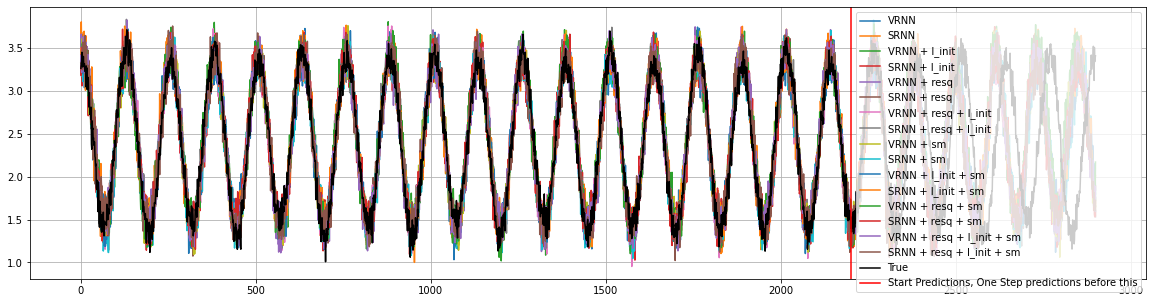

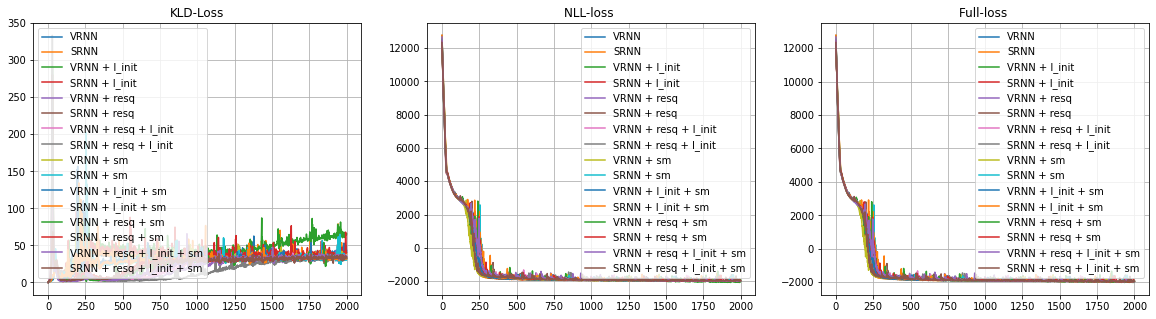

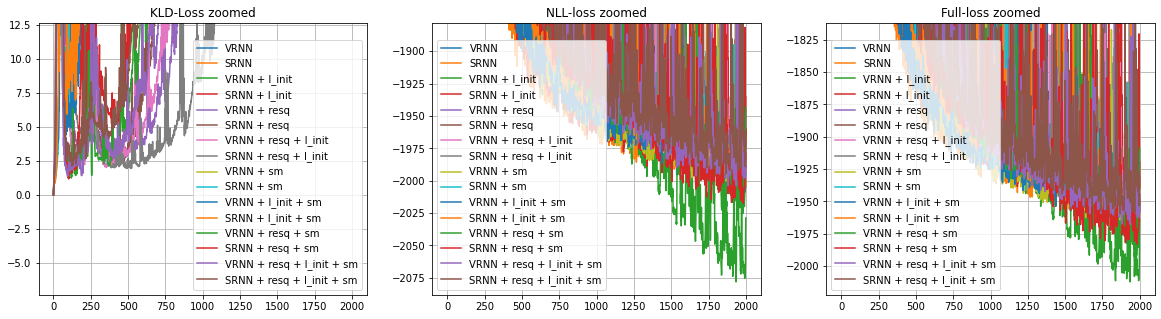

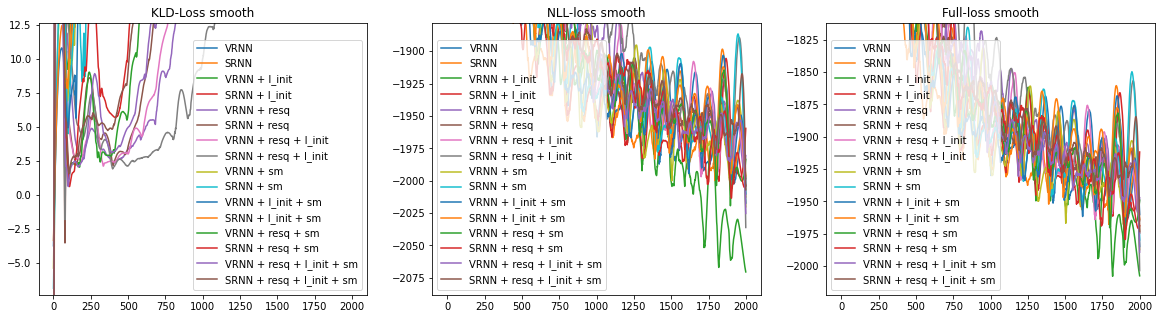

In [21]:
# See a subset of models in next codeblock
for model in modellist:
  model.eval()
transform_x = False
xtest=next(iter(test_loader_sinus)).to(device)
xtest = scale_to_zero_one(xtest, xtest, reverse=False, transform=transform_x)

losslistKLD = lossKLD_allmodels
losslistNLL = lossNLL_allmodels
fulllosslist =np.array(losslistKLD) + np.array(losslistNLL)


tsteps=3*timeblocks//4



plt.figure(figsize=(20,5))


for model, name in zip(modellist, namelist):
  predictions=[]
  one_step, preds, Prediction_loss = model.PredictionAfterTsteps(xtest.float(), tsteps=tsteps)
  one_step = torch.stack(one_step,dim = 1)
  preds = torch.stack(preds,dim = 1)
  predictions = preds[0,:,:]
  one_step = one_step[0,:,:]
  plt.plot(np.ravel(np.array(torch.cat((one_step,predictions), dim = 0).cpu().numpy())),label=name)

plt.plot(xtest[0,1:,:].view(-1).cpu(),label='True',c='black')
plt.axvline(x=xtest[0,:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
plt.legend()
plt.grid()

fig, ax = plt.subplots(1, 3, figsize = (20,5))
for lossKLD, name in zip(losslistKLD, namelist):
  ax[0].plot(lossKLD, label = name)
  ax[0].grid()
  ax[0].title.set_text('KLD-Loss')
for lossNLL_hist, name in zip(losslistNLL, namelist):
  ax[1].plot(lossNLL_hist, label = name)
  ax[1].title.set_text('NLL-loss ')
for fullloss, name in zip(fulllosslist, namelist):
  ax[2].plot(fullloss, label = name)
  ax[2].title.set_text('Full-loss ')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()


fig, ax = plt.subplots(1, 3, figsize = (20,5))
for lossKLD, name in zip(losslistKLD, namelist):
  ax[0].plot(lossKLD, label = name)
  ax[0].grid()
  ax[0].title.set_text('KLD-Loss zoomed')
for lossNLL_hist, name in zip(losslistNLL, namelist):
  ax[1].plot(lossNLL_hist, label = name)
  ax[1].title.set_text('NLL-loss zoomed')
for fullloss, name in zip(fulllosslist, namelist):
  ax[2].plot(fullloss, label = name)
  ax[2].title.set_text('Full-loss zoomed')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_ylim((np.min(lossKLD[200:])-10, np.min(lossKLD[200:])+10))
ax[1].set_ylim((np.min(losslistNLL)-10, np.min(losslistNLL)+200))

ax[2].set_ylim((np.min(fulllosslist)-10, np.min(fulllosslist)+200))


smoothingwindow = 101
fig, ax = plt.subplots(1, 3, figsize = (20,5))
for lossKLD, name in zip(losslistKLD, namelist):
  ax[0].plot(savgol_filter(tuple(lossKLD), smoothingwindow, 3), label = name)
  ax[0].grid()
  ax[0].title.set_text('KLD-Loss smooth')
for lossNLL_hist, name in zip(losslistNLL, namelist):
  savgol_filter(tuple(lossNLL_hist), smoothingwindow, 3)
  ax[1].plot(savgol_filter(tuple(lossNLL_hist), smoothingwindow, 3), label = name)
  ax[1].title.set_text('NLL-loss smooth')
for fullloss, name in zip(fulllosslist, namelist):
  ax[2].plot(savgol_filter(tuple(fullloss), smoothingwindow, 3), label = name)
  ax[2].title.set_text('Full-loss smooth')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_ylim((np.min(lossKLD[200:])-10, np.min(lossKLD[200:])+10))
ax[1].set_ylim((np.min(losslistNLL)-10, np.min(losslistNLL)+200))

ax[2].set_ylim((np.min(fulllosslist)-10, np.min(fulllosslist)+200))

plt.show()

In [73]:
# Function for easy plotting
def plot_subset(pltmodels,namelist,modellist):
  with torch.no_grad():
    namelist_subset = [namelist[i] for i in pltmodels]
    modellist_subset = [modellist[i] for i in pltmodels]

    for model in modellist_subset:
      model.eval()
    transform_x = False
    xtest=next(iter(test_loader_sinus)).to(device)
    xtest = scale_to_zero_one(xtest, xtest, reverse=False, transform=transform_x)

    losslistKLD = [lossKLD_allmodels[i] for i in pltmodels]
    losslistNLL = [lossNLL_allmodels[i] for i in pltmodels]
    fulllosslist =np.array(losslistKLD) + np.array(losslistNLL)


    tsteps=3*timeblocks//4



    plt.figure(figsize=(20,5))


    for model, name in zip(modellist_subset, namelist_subset):
      predictions=[]
      recons, preds, Prediction_loss = model.PredictionAfterTsteps_warmup(xtest.float(), tsteps=tsteps)
      #print('Wi Warmup prediction loss: '+str(name)+' '+str(Prediction_loss.sum(dim=1).mean().cpu().numpy()))
      print('Wi Warmup prediction loss: '+str(name)+' '+str(Prediction_loss.mean().cpu().numpy()))
      one_step, preds, Prediction_loss = model.PredictionAfterTsteps(xtest.float(), tsteps=tsteps)
      #print('No warmup prediction loss: '+str(name)+' '+str(Prediction_loss.sum(dim=1).mean().cpu().numpy()))
      print('No Warmup prediction loss: '+str(name)+' '+str(Prediction_loss.mean().cpu().numpy()))

      one_step = torch.stack(one_step,dim = 1)
      preds = torch.stack(preds,dim = 1)
      predictions = preds[0,:,:]
      one_step = one_step[0,:,:]
      plt.plot(np.ravel(np.array(torch.cat((one_step,predictions), dim = 0).cpu().numpy())),label=name)

    plt.plot(xtest[0,1:,:].view(-1).cpu(),label='True',c='black')
    plt.axvline(x=xtest[0,:tsteps,:].view(-1).shape[0], label='Start Predictions, One Step predictions before this',c='red')
    plt.legend()
    plt.grid()

    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    for lossKLD, name in zip(losslistKLD, namelist_subset):
      ax[0].plot(lossKLD, label = name)
      ax[0].title.set_text('KLD-Loss')
    for lossNLL_hist, name in zip(losslistNLL, namelist_subset):
      ax[1].plot(lossNLL_hist, label = name)
      ax[1].title.set_text('NLL-loss ')
    for fullloss, name in zip(fulllosslist, namelist_subset):
      ax[2].plot(fullloss, label = name)
      ax[2].title.set_text('Full-loss ')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()


    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    for lossKLD, name in zip(losslistKLD, namelist_subset):
      ax[0].plot(lossKLD, label = name)
      ax[0].title.set_text('KLD-Loss zoomed')
    for lossNLL_hist, name in zip(losslistNLL, namelist_subset):
      ax[1].plot(lossNLL_hist, label = name)
      ax[1].title.set_text('NLL-loss zoomed')
    for fullloss, name in zip(fulllosslist, namelist_subset):
      ax[2].plot(fullloss, label = name)
      ax[2].title.set_text('Full-loss zoomed')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[0].set_ylim((np.min(lossKLD[200:])-10, np.min(lossKLD[200:])+10))
    ax[1].set_ylim((np.min(losslistNLL)-10, np.min(losslistNLL)+200))

    ax[2].set_ylim((np.min(fulllosslist)-10, np.min(fulllosslist)+200))


    smoothingwindow = 201
    smoothingorder = 5
    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    for lossKLD, name in zip(losslistKLD, namelist_subset):
      ax[0].plot(savgol_filter(tuple(lossKLD), smoothingwindow, smoothingorder), label = name)
      ax[0].title.set_text('KLD-Loss smooth')
    for lossNLL_hist, name in zip(losslistNLL, namelist_subset):
      savgol_filter(tuple(lossNLL_hist), smoothingwindow, smoothingorder)
      ax[1].plot(savgol_filter(tuple(lossNLL_hist), smoothingwindow, smoothingorder), label = name)
      ax[1].title.set_text('NLL-loss smooth')
    for fullloss, name in zip(fulllosslist, namelist_subset):
      ax[2].plot(savgol_filter(tuple(fullloss), smoothingwindow, smoothingorder), label = name)
      ax[2].title.set_text('Full-loss smooth')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[0].set_ylim((np.min(lossKLD[200:])-10, np.min(lossKLD[200:])+10))
    ax[1].set_ylim((np.min(losslistNLL)-10, np.min(losslistNLL)+200))

    ax[2].set_ylim((np.min(fulllosslist)-10, np.min(fulllosslist)+200))

    plt.show()

Wi Warmup prediction loss: VRNN + l_init 197.30844
No Warmup prediction loss: VRNN + l_init 197.08665
Wi Warmup prediction loss: VRNN + resq 177.65094
No Warmup prediction loss: VRNN + resq 177.16284
Wi Warmup prediction loss: VRNN + resq + l_init 162.67494
No Warmup prediction loss: VRNN + resq + l_init 162.30568
Wi Warmup prediction loss: VRNN + sm 149.69484
No Warmup prediction loss: VRNN + sm 149.79344
Wi Warmup prediction loss: VRNN + l_init + sm 139.68733
No Warmup prediction loss: VRNN + l_init + sm 139.36961
Wi Warmup prediction loss: VRNN + resq + sm 156.50287
No Warmup prediction loss: VRNN + resq + sm 156.22427
Wi Warmup prediction loss: VRNN + resq + l_init + sm 163.76303
No Warmup prediction loss: VRNN + resq + l_init + sm 163.69806


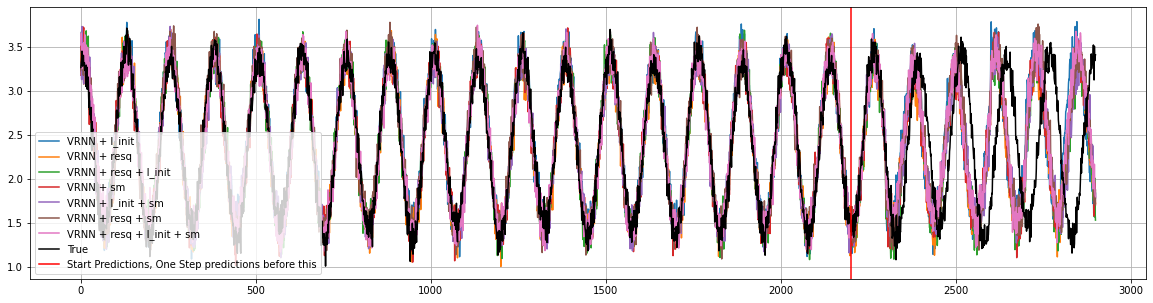

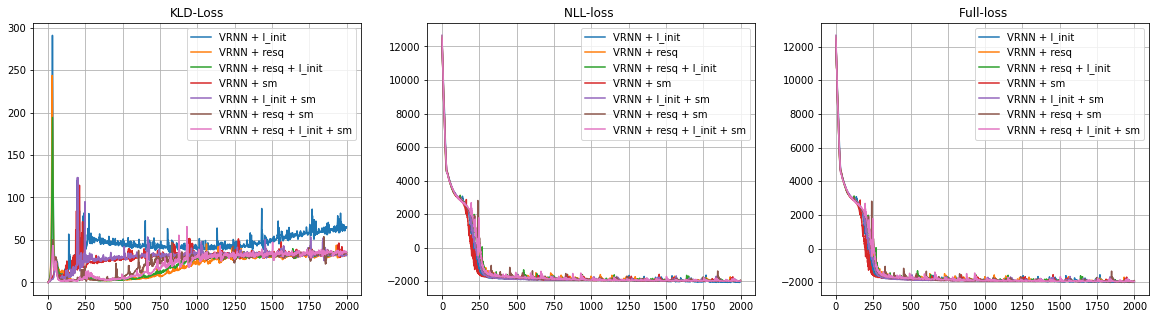

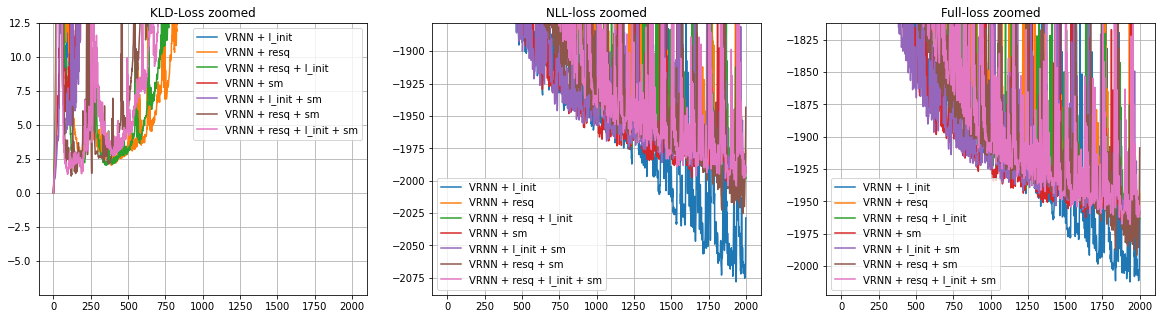

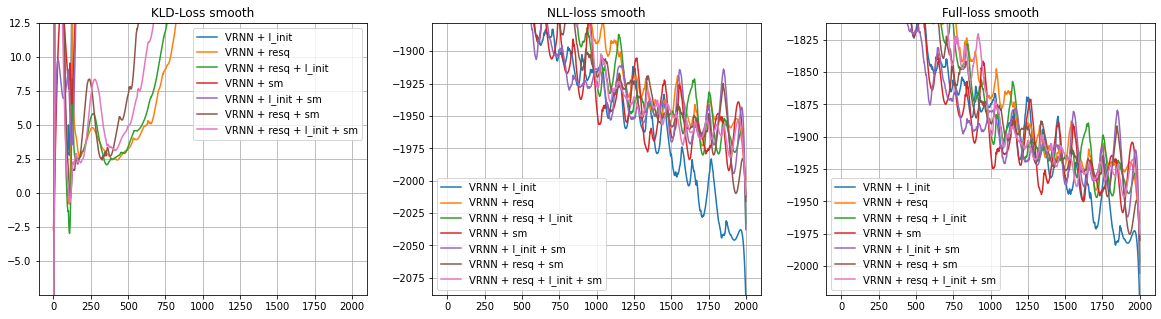

Wi Warmup prediction loss: VRNN + l_init 196.90068
No Warmup prediction loss: VRNN + l_init 197.14897
Wi Warmup prediction loss: VRNN + l_init + sm 139.27106
No Warmup prediction loss: VRNN + l_init + sm 139.39732
Wi Warmup prediction loss: VRNN + resq + sm 156.44066
No Warmup prediction loss: VRNN + resq + sm 156.38794


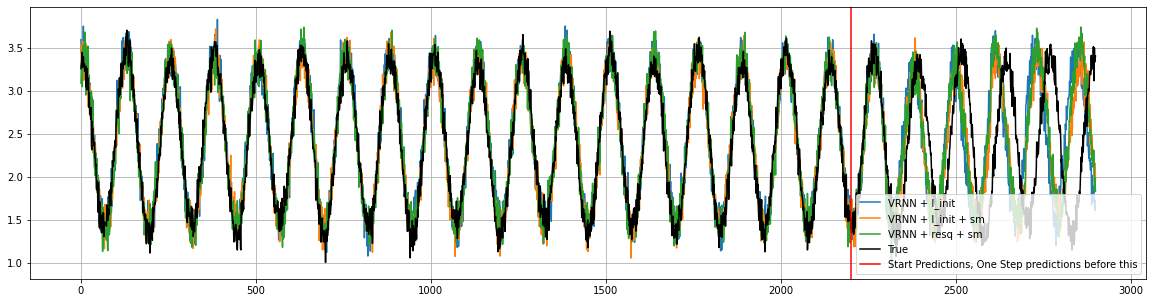

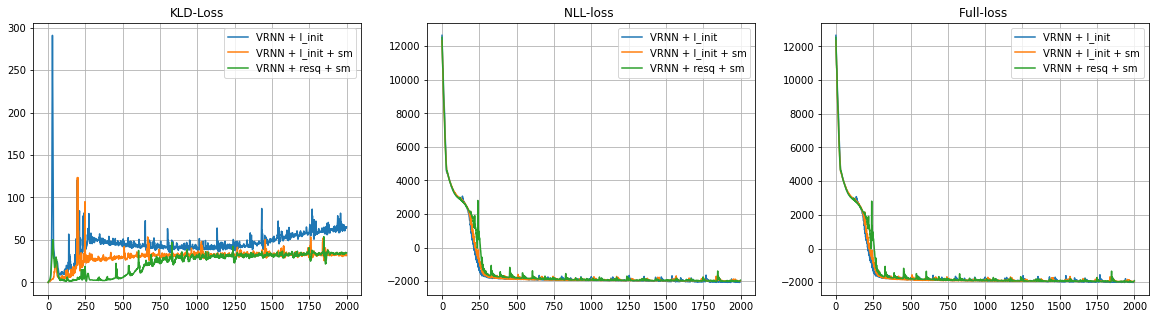

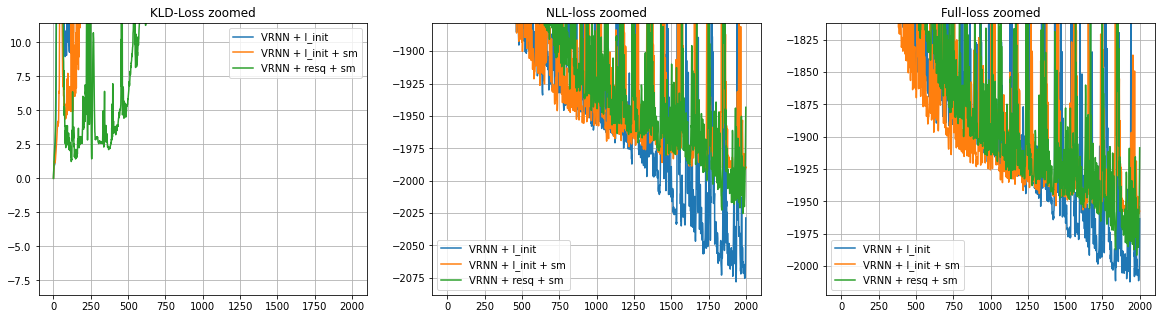

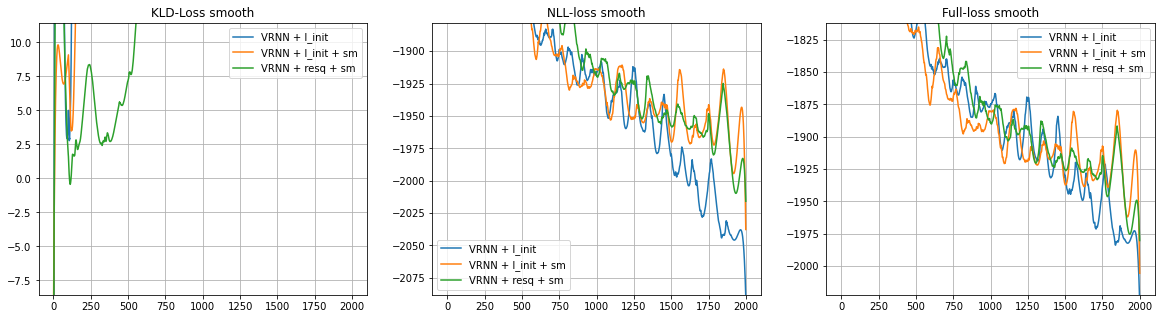

In [77]:
pltmodels = [2,4,6,8,10,12,14] ## All VRNN 
plot_subset(pltmodels,namelist,modellist)

#8, 10, 12, 14
pltmodels = [2,10,12] ## Best and worst VRNN 
plot_subset(pltmodels,namelist,modellist)

Wi Warmup prediction loss: SRNN 173.3922
No Warmup prediction loss: SRNN 173.4252
Wi Warmup prediction loss: SRNN + l_init 156.35046
No Warmup prediction loss: SRNN + l_init 156.34206
Wi Warmup prediction loss: SRNN + resq 153.22606
No Warmup prediction loss: SRNN + resq 153.24738
Wi Warmup prediction loss: SRNN + resq + l_init 160.97665
No Warmup prediction loss: SRNN + resq + l_init 161.01476
Wi Warmup prediction loss: SRNN + sm 129.97676
No Warmup prediction loss: SRNN + sm 130.17053
Wi Warmup prediction loss: SRNN + l_init + sm 155.66524
No Warmup prediction loss: SRNN + l_init + sm 155.61034
Wi Warmup prediction loss: SRNN + resq + sm 170.51387
No Warmup prediction loss: SRNN + resq + sm 170.32463
Wi Warmup prediction loss: SRNN + resq + l_init + sm 159.52025
No Warmup prediction loss: SRNN + resq + l_init + sm 159.44284


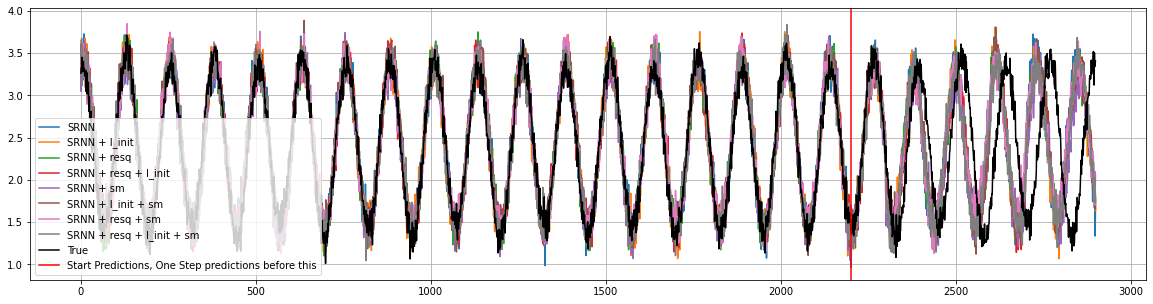

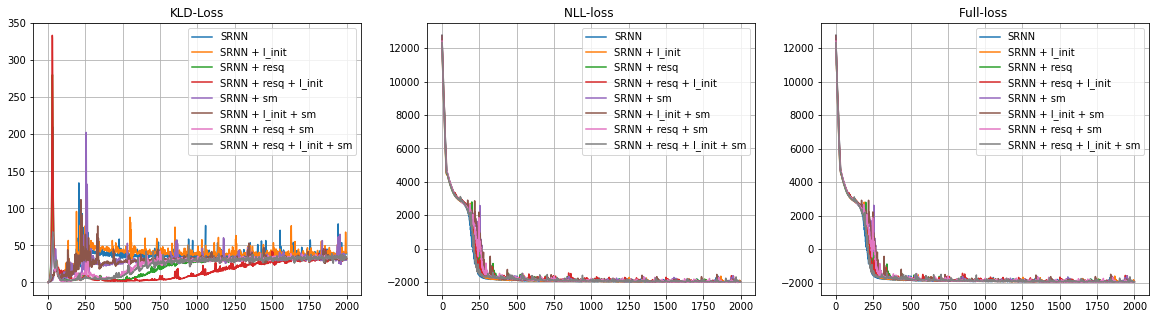

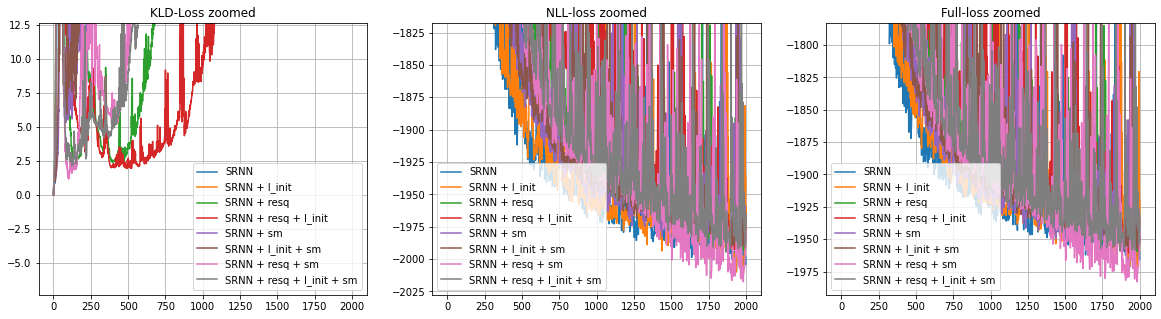

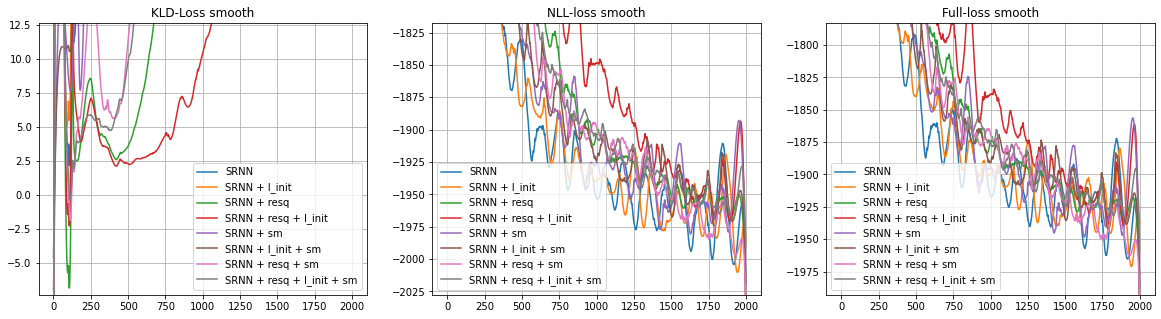

Wi Warmup prediction loss: SRNN 173.43927
No Warmup prediction loss: SRNN 173.5194
Wi Warmup prediction loss: SRNN + resq 153.50127
No Warmup prediction loss: SRNN + resq 153.31339
Wi Warmup prediction loss: SRNN + sm 129.8004
No Warmup prediction loss: SRNN + sm 129.87082


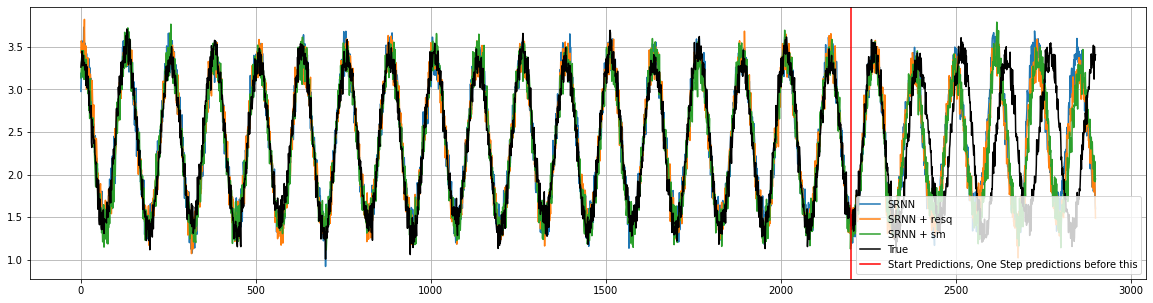

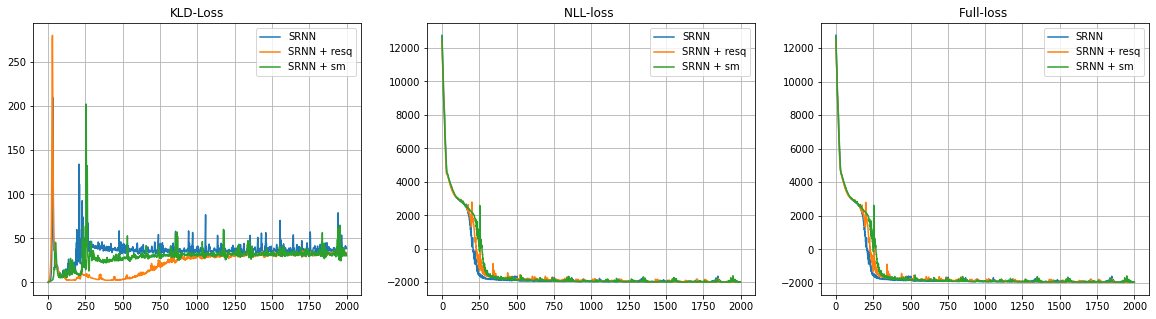

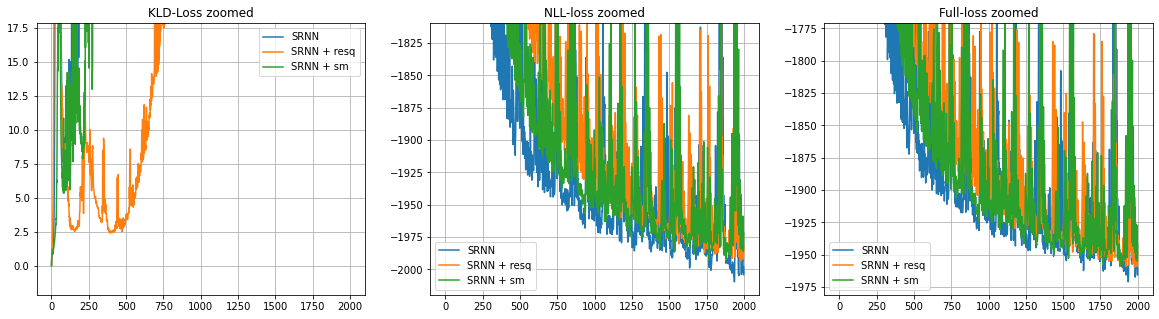

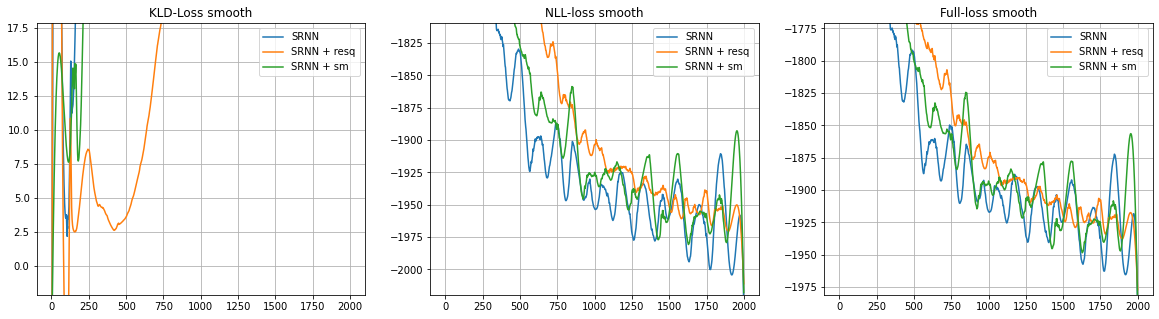

In [78]:
pltmodels = [1,3,5,7,9,11,13,15] ## All of SRNN 
plot_subset(pltmodels,namelist,modellist)


pltmodels = [1,5,9] ## Subset of worst and best SRNN 
plot_subset(pltmodels,namelist,modellist)

Wi Warmup prediction loss: SRNN + sm 129.75206
No Warmup prediction loss: SRNN + sm 129.95685
Wi Warmup prediction loss: VRNN + l_init + sm 139.31047
No Warmup prediction loss: VRNN + l_init + sm 139.4569


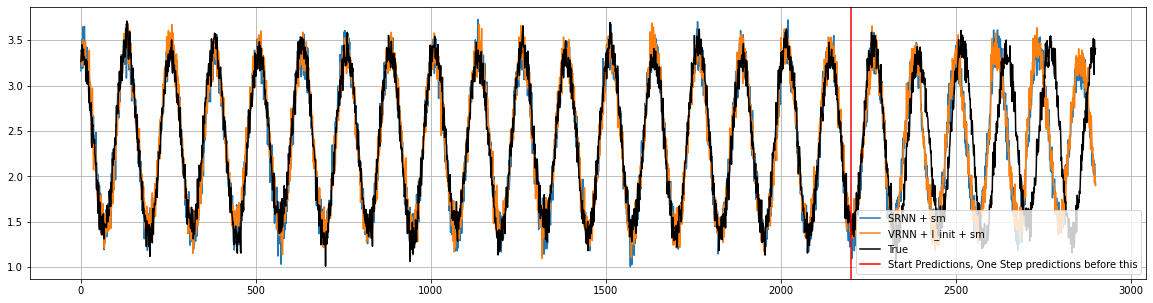

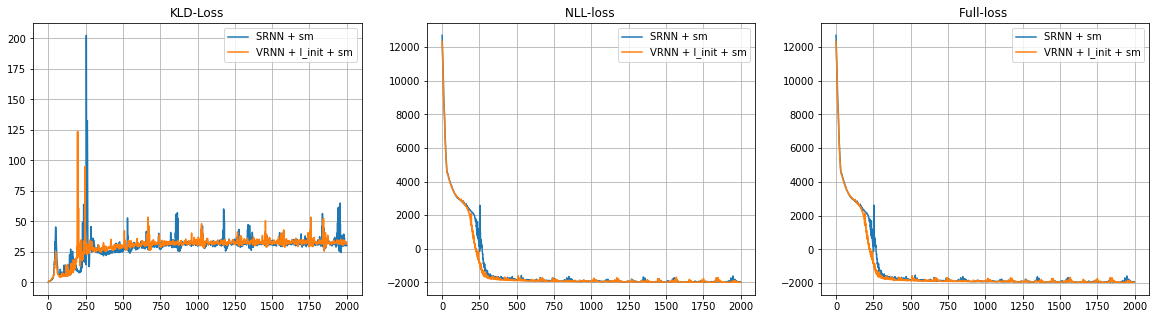

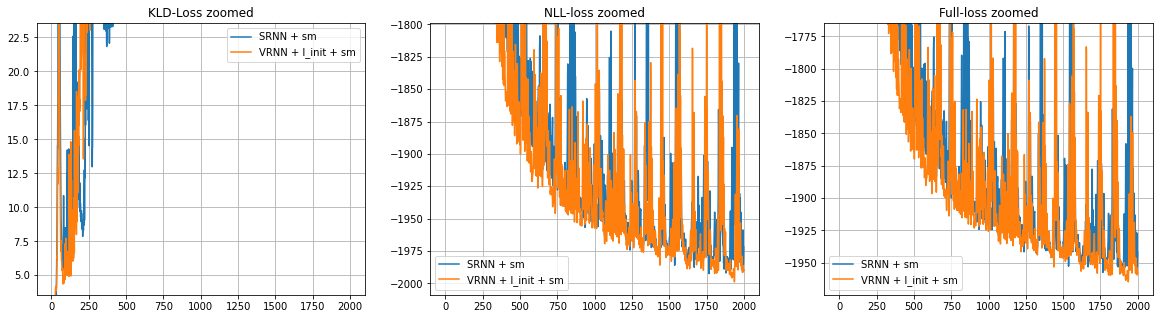

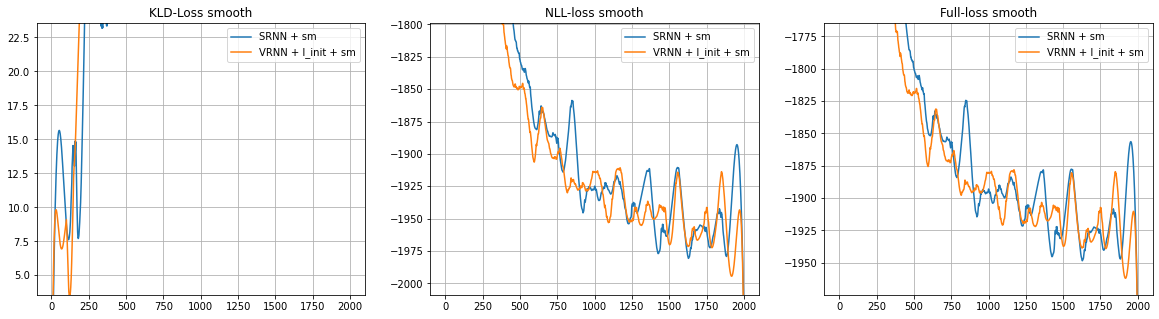

In [79]:

pltmodels = [9, 10] ## VRNN and SRNN best model 
plot_subset(pltmodels,namelist,modellist)
